Rentabilidade Analítica / Churn 

### Importando as bibliotecas

In [497]:
#Básicas
import pandas as pd
import numpy as np

#visualização
import matplotlib.pyplot as plt
import seaborn as sns

#pre-processing
from sklearn import preprocessing
from sklearn.model_selection import KFold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import StandardScaler
from feature_engine.encoding import CountFrequencyEncoder

#Modelagem
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import IsolationForest
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LinearRegression
import lightgbm as lgb

#otimização de modelos
from sklearn.model_selection import GridSearchCV

#Cluesterização
from sklearn.metrics import silhouette_score 
from sklearn.cluster import KMeans
from sklearn.cluster import MeanShift
from sklearn.cluster import DBSCAN

#estatística e métricas
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

### Importando o dataset

In [3]:
#Bibliotecas para extração de dados excel necessárias para esse arquivo:
#conda install -c anaconda xlrd  
#conda install -c anaconda openpyxl 
df = pd.read_excel('CASE_Rentabilidade.xlsx', engine="openpyxl", header=1)
df.head()

,Número do Cliente,MCC,Data Apuração,Data de Entrada do Cliente,Canal,Cidade,Volume Transacionado,Quantidade de Transações,Net MDR,Aluguel,Pre-pagamento,Total,Pre-pagamento.1,Equipamento/Logística,Comissões,Transacionais,Outros,Total.1,Margem final
0,100910138884288,5309,2016-10-01,2016-01-07,Canal 3,Niterói,189012.41,2235.0,122.270875,74.0883,0.000000,196.359175,0.000000,-141.112685,0.0,-143.139975,-46.385376,-330.638035,-134.278860
1,100101693498007,5963,2016-10-01,2015-12-10,Canal 3,Rio de Janeiro,0.00,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,-13.000000,0.0,0.000000,0.000000,-13.000000,-13.000000
2,100990966870135,5814,2016-10-01,2016-03-29,Canal 3,Rio de Janeiro,240922.64,1190.0,1149.339125,143.3850,4317.057065,5609.781190,-1525.626864,-312.125140,0.0,-108.582375,-146.240869,-2092.575248,3517.205942
3,100112746462403,7230,2016-10-01,2016-07-26,Canal 3,Niterói,0.00,0.0,0.000000,0.0000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,-24.013815,-24.013815,-24.013815
4,100101114264588,7997,2016-10-01,2016-04-13,Canal 1,Brasília,3634.70,56.0,61.734500,0.0000,0.000000,61.734500,0.000000,0.000000,0.0,-12.582487,-52.545135,-65.127623,-3.393123


In [83]:
df.shape

(12456, 19)

In [4]:
#vou renomear o nome de algumas features para evitar problemas futuros
df.rename(columns={'Número do Cliente': 'Nr_cliente',
                   'Data Apuração': 'Data_apuracao',
                   'Data de Entrada do Cliente': 'Data_entrada',
                   'Volume Transacionado': 'Volume_transacionado',
                   'Quantidade de Transações': 'Qnt_transacoes',
                   'Net MDR': 'Net_MDR',
                   'Pre-pagamento': 'Pre_pagamento',
                   'Pre-pagamento.1': 'Pre_pagamento_1',
                   'Equipamento/Logística': 'Equipamento_Logistica',
                   'Comissões': 'Comissoes',
                   'Total.1': 'Total_1',
                   'Margem final': 'Margem_final'}, inplace=True)

In [195]:
#df["Dia"] = df['Data_entrada'].map(lambda x: x.day)
#df["Mes"] = df['Data_entrada'].map(lambda
                                             x: x.month)
#df["Ano"] = df['Data_entrada'].map(lambda x: x.year)
#del df['Data_entrada']

### Análise Exploratório dos Dados

In [354]:
def normal(df, col, threshold=0.05):
    try:
        zscore, p_value = stats.normaltest(df[col])
        if p_value < threshold:
            result = 'not_normal'
        else:
            result = 'normal'
    except:
        zscore = p_value = np.nan
        result = 'not_applicable'
    return result

def outliers_count_IQR(df, col):
    try:
        if len(df[col].unique())>2: # if para eliminar features binárias
            q1 = df[col].quantile(0.25)
            q3 = df[col].quantile(0.75)
            iqr_range = q3 - q1
            lower = q1 - 1.5*iqr_range
            upper = q3 + 1.5*iqr_range
            out_low = df[df[col] < lower].count()[0]
            out_up = df[df[col] > upper].count()[0]
            outliers = out_low + out_up
            outliers_perc = round(outliers / df.shape[0],2)
        else:
            outliers = np.nan
            outliers_perc = np.nan
    except:
        outliers = np.nan
        outliers_perc = np.nan
    return outliers, outliers_perc


#o que interessa
def EDA(df):
    df= df.rename(columns=str.lower)

    eda_df = {}
    eda_df['Amount_NaN'] = df.isnull().sum()
    eda_df['%_NaN'] = df.isnull().mean().round(2)
    eda_df['DType'] = df.dtypes
    eda_df['Amount_Data'] = df.count()
    
    colunas = df.columns.tolist()
      
    eda_df['Amount_Unique'] = pd.Series(map(lambda x: len(df[x].unique().tolist()), colunas), index=colunas)

    eda_df['Min'] = df.min()
    eda_df['Max'] = df.max()
    eda_df['Mean'] = df.mean().round(3)
    #eda_df['STD'] = df.std().round(3)
    
    eda_df['Normality'] = pd.Series(map(lambda x: normal(df, x), colunas), index=colunas)
    eda_df['Amount_Outliers'] = pd.Series(map(lambda x: outliers_count_IQR(df, x)[0], colunas), index=colunas)
    eda_df['%_Outliers'] = pd.Series(map(lambda x: outliers_count_IQR(df, x)[1], colunas), index=colunas)
    df = pd.DataFrame(eda_df)
    return df.loc[colunas,:]

In [7]:
EDA(df)

,Amount_NaN,%_NaN,DType,Amount_Data,Amount_Unique,Min,Max,Normality,Amount_Outliers,%_Outliers
nr_cliente,0,0.0,int64,12456,3194,100100026313922,100999875040090,not_applicable,1958.0,0.16
mcc,0,0.0,int64,12456,190,742,9402,not_applicable,138.0,0.01
data_apuracao,0,0.0,datetime64[ns],12456,5,2016-10-01 00:00:00,2017-02-01 00:00:00,not_applicable,0.0,0.00
data_entrada,0,0.0,datetime64[ns],12456,430,2014-04-11 00:00:00,2017-02-02 00:00:00,not_applicable,360.0,0.03
canal,0,0.0,object,12456,3,Canal 1,Canal 3,not_applicable,NaN,NaN
cidade,0,0.0,object,12456,343,Adamantina,Xinguara,not_applicable,NaN,NaN
volume_transacionado,0,0.0,float64,12456,9195,0.0,15133465.78,not_applicable,1511.0,0.12
qnt_transacoes,0,0.0,float64,12456,1763,0.0,80892.0,not_applicable,1710.0,0.14
net_mdr,0,0.0,float64,12456,8883,-1741.785312,98896.565625,not_applicable,1262.0,0.10
aluguel,0,0.0,float64,12456,749,0.0,1924.8075,not_applicable,386.0,0.03


In [8]:
#Algumas conclusões rápidas

#1- Temos 12465 linhas de dados, porém 3194 dados unicos do "número do cliente", que imagino ser o id de cada cliente,
#ou seja, temos dados de 3.194 clientes diferentes no dataset - vou tentar agrupar e analisar isso

#2 - Não temos dados faltantes, porém mtos dados com valor 0.00 que pode ser zero mesmo ou um dado não preenchido - analisar
#3 - duas features datetime - data de entrada do cliente e de apuração 
#4 - podemos notar algumas features com elevada % de outliers (método quartis)
#5 - aparentemente algumas features são diretamente correlacionadas umas com as outras, vou 
#confirmar utilizando um heatmap

In [60]:
#MCC na verdade é um objeto
df['MCC'] = df['MCC'].astype(str)
categorical = ['MCC','Cidade']

for cat_column in categorical:
    text_label = preprocessing.LabelEncoder()
    num_label = text_label.fit_transform(df[cat_column])
    df[cat_column + '_cat'] = num_label

In [63]:
dummies = ['Canal']

df_heatmap1 = pd.get_dummies(df, columns = dummies)

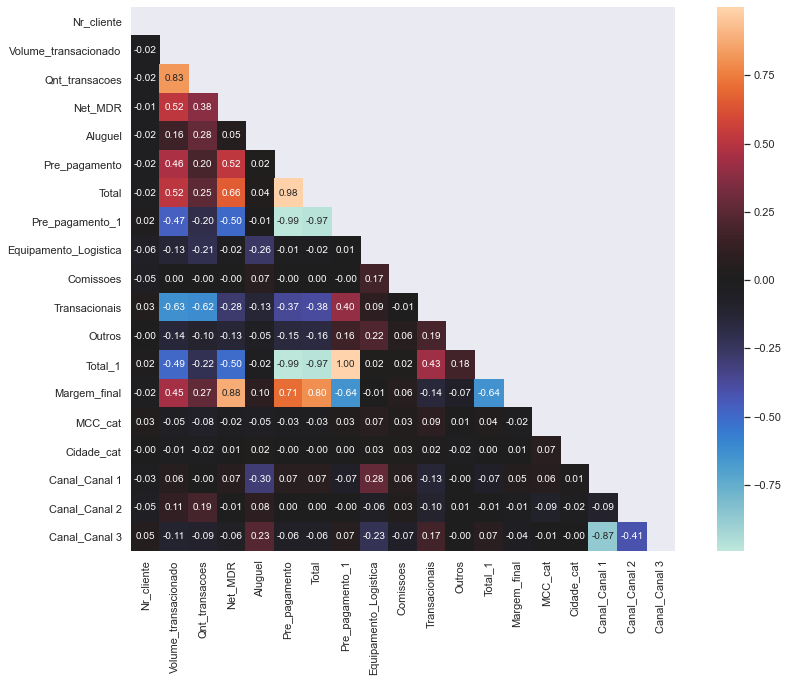

In [64]:
# Plotando um mapa de calor das correlações com todas as variáveis
corrmat = df_heatmap1.corr()
sns.set(font_scale=1.0)
f, ax = plt.subplots(figsize=(15, 10))

mask = np.triu(np.ones_like(corrmat, dtype=bool))
hm = sns.heatmap(corrmat, 
                 mask=mask,
                 cmap='icefire',
                 cbar=True, 
                 annot=True, 
                 square=True, 
                 fmt='.2f', 
                 annot_kws={'size': 10}, 
                 yticklabels=corrmat.columns, 
                 xticklabels=corrmat.columns)

In [10]:
#podemos notar grande correlação entre as features pre_pagamento/pre_pagamento_1/Total/Total1
#vou analisar para excluir algumas, pois podem causar ruído desnecessário

In [138]:
#vou isolar um "Nr_cliente" para entender o que varia e o que é igual em cada linha para o mesmo cliente
df.Nr_cliente.value_counts()

100158256909302    5
100102506940851    5
100130384814402    5
100147358966082    5
100120969267519    5
                  ..
100210052147268    1
100152003729522    1
100137636354962    1
100144244567004    1
100347561667167    1
Name: Nr_cliente, Length: 3194, dtype: int64

In [139]:
df.loc[df.Nr_cliente == 100910138884288]

,Nr_cliente,MCC,Data_apuracao,Data_entrada,Canal,Cidade,Volume_transacionado,Qnt_transacoes,Net_MDR,Aluguel,Pre_pagamento,Total,Pre_pagamento_1,Equipamento_Logistica,Comissoes,Transacionais,Outros,Total_1,Margem_final
0,100910138884288,5309,2016-10-01,2016-01-07,Canal 3,Niterói,189012.41,2235.0,122.270875,74.088300,0.0,196.359175,0.0,-141.112685,0.0,-143.139975,-46.385376,-330.638035,-134.278860
3924,100910138884288,5309,2016-11-01,2016-01-07,Canal 3,Niterói,166107.78,2040.0,115.339500,74.079225,0.0,189.418725,0.0,-199.710421,0.0,-125.638837,-94.978951,-420.328209,-230.909484
5955,100910138884288,5309,2016-12-01,2016-01-07,Canal 3,Niterói,250275.46,2847.0,124.329875,38.242050,0.0,162.571925,0.0,-17.351555,0.0,-173.468625,0.000000,-190.820180,-28.248255
7300,100910138884288,5309,2017-01-01,2016-01-07,Canal 3,Niterói,203025.64,2352.0,85.532812,0.000000,0.0,85.532812,0.0,-17.358913,0.0,-144.555675,-27.013197,-188.927786,-103.394973
11370,100910138884288,5309,2017-02-01,2016-01-07,Canal 3,Niterói,188855.63,2142.0,103.881875,143.385000,0.0,247.266875,0.0,-125.374720,0.0,-131.024850,-248.503949,-504.903519,-257.636644


In [140]:
#mais um para confirmar algumas coisas
df.loc[df.Nr_cliente == 100130384814402]

,Nr_cliente,MCC,Data_apuracao,Data_entrada,Canal,Cidade,Volume_transacionado,Qnt_transacoes,Net_MDR,Aluguel,Pre_pagamento,Total,Pre_pagamento_1,Equipamento_Logistica,Comissoes,Transacionais,Outros,Total_1,Margem_final
1535,100130384814402,7997,2016-10-01,2016-01-07,Canal 1,Campo Grande,41093.76,313.0,627.906250,0.0,467.644075,1095.550325,-120.415900,0.0,0.0,-22.274587,0.000000,-142.690487,952.859838
3524,100130384814402,7997,2016-11-01,2016-01-07,Canal 1,Campo Grande,43076.57,328.0,657.309125,0.0,338.273195,995.582320,-97.600022,0.0,0.0,-21.398850,0.000000,-118.998872,876.583448
5389,100130384814402,7997,2016-12-01,2016-01-07,Canal 1,Campo Grande,38602.59,296.0,589.992250,0.0,166.595520,756.587770,-93.164489,0.0,0.0,-20.023988,-17.205802,-130.394278,626.193492
9250,100130384814402,7997,2017-01-01,2016-01-07,Canal 1,Campo Grande,43357.59,335.0,822.035781,0.0,385.538190,1207.573971,-101.233185,0.0,0.0,-21.702863,-26.127100,-149.063148,1058.510824
11867,100130384814402,7997,2017-02-01,2016-01-07,Canal 1,Campo Grande,43546.99,324.0,809.022812,0.0,486.599655,1295.622467,-132.957076,0.0,0.0,-19.969537,0.000000,-152.926613,1142.695854


In [141]:
#Conclusões

#as datas de entrada são sempre as mesmas para cada cliente
#MCC também é o msm para cada cliente, assim como o Canal e Cidade
#o que muda e manda nas outras features é a data de apuração, provavelmente é a data de fechamento tributario mensal dos cliente\
#(sempre no dia 1 de cada mês ativo), e começa a contar depois da primeira transação do mesmo

#com as datas de apuração e entrada dos cliente que podemos anlisar o Churn - lembrando que as datas iniciais e finais de apuração:
#pelo EDA
#data incial: 2016-10-01
#data final: 2017-02-01
#ou seja, temos dados dos cliente de outubro de 2016 até fevereiro de 2017 (5 meses de dados)

In [142]:
#confirmando
display(min(df.Data_apuracao))
display(max(df.Data_apuracao))

Timestamp('2016-10-01 00:00:00')

Timestamp('2017-02-01 00:00:00')

In [144]:
df.groupby('Nr_cliente')['Data_apuracao'].count().sort_values(ascending = False) 

Nr_cliente
100100026313922    5
100130474316168    5
100130943553669    5
100100082815567    5
100130912918786    5
                  ..
100182276783525    1
100182340984803    1
100183598834028    1
100183790243202    1
100999875040090    1
Name: Data_apuracao, Length: 3194, dtype: int64

In [146]:
df.loc[df.Nr_cliente == 100130384814402]

,Nr_cliente,MCC,Data_apuracao,Data_entrada,Canal,Cidade,Volume_transacionado,Qnt_transacoes,Net_MDR,Aluguel,Pre_pagamento,Total,Pre_pagamento_1,Equipamento_Logistica,Comissoes,Transacionais,Outros,Total_1,Margem_final
1535,100130384814402,7997,2016-10-01,2016-01-07,Canal 1,Campo Grande,41093.76,313.0,627.906250,0.0,467.644075,1095.550325,-120.415900,0.0,0.0,-22.274587,0.000000,-142.690487,952.859838
3524,100130384814402,7997,2016-11-01,2016-01-07,Canal 1,Campo Grande,43076.57,328.0,657.309125,0.0,338.273195,995.582320,-97.600022,0.0,0.0,-21.398850,0.000000,-118.998872,876.583448
5389,100130384814402,7997,2016-12-01,2016-01-07,Canal 1,Campo Grande,38602.59,296.0,589.992250,0.0,166.595520,756.587770,-93.164489,0.0,0.0,-20.023988,-17.205802,-130.394278,626.193492
9250,100130384814402,7997,2017-01-01,2016-01-07,Canal 1,Campo Grande,43357.59,335.0,822.035781,0.0,385.538190,1207.573971,-101.233185,0.0,0.0,-21.702863,-26.127100,-149.063148,1058.510824
11867,100130384814402,7997,2017-02-01,2016-01-07,Canal 1,Campo Grande,43546.99,324.0,809.022812,0.0,486.599655,1295.622467,-132.957076,0.0,0.0,-19.969537,0.000000,-152.926613,1142.695854


In [567]:
df_filtrada = df.groupby(['Data_apuracao']).sum()
df_filtrada

,Nr_cliente,Volume_transacionado,Qnt_transacoes,Net_MDR,Aluguel,Pre_pagamento,Total,Pre_pagamento_1,Equipamento_Logistica,Comissoes,Transacionais,Outros,Total_1,Margem_final,MCC_cat,Cidade_cat
Data_apuracao,,,,,,,,,,,,,,,,
2016-10-01,229846064514068864,9.633110e+07,943662.3,466473.676991,99895.503675,1.009293e+06,1.575662e+06,-6.686220e+05,-52188.665222,-25645.9500,-91969.337863,-39521.662655,-8.779476e+05,6.977145e+05,216669,500409
2016-11-01,243102637725642240,1.175732e+08,956567.2,509835.445824,121468.185300,1.129651e+06,1.760954e+06,-7.568483e+05,-51205.690547,-31263.3750,-101219.702988,-40715.487920,-9.812525e+05,7.797017e+05,226958,518021
2016-12-01,252631737075979936,1.177103e+08,1068943.8,556566.945840,132089.982750,1.863119e+06,2.551776e+06,-1.392623e+06,-56385.951336,-84279.5250,-104904.140313,-35377.103376,-1.673570e+06,8.782060e+05,234819,537926
2017-01-01,259563687403143264,1.134181e+08,1051068.7,697286.410786,140694.879600,1.540254e+06,2.378235e+06,-9.395753e+05,-65910.518413,-46577.4375,-117040.563269,-53360.343716,-1.222464e+06,1.155771e+06,241074,549724
2017-02-01,263086862556886880,9.966893e+07,985028.6,577278.329723,159795.857925,9.520100e+05,1.689084e+06,-4.616177e+05,-60308.708435,-44217.9375,-98444.412537,-54253.629818,-7.188424e+05,9.702418e+05,244100,557223


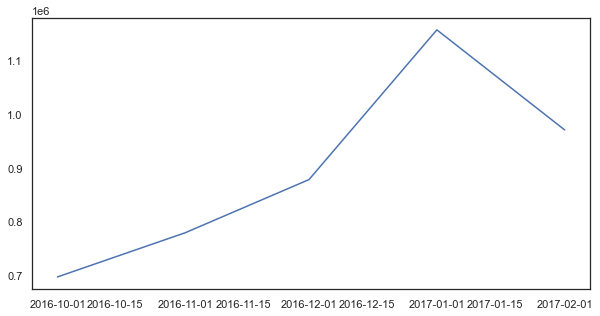

In [571]:
sns.set_style('white')
plt.figure(figsize=(10,5))
plt.plot(df_filtrada['Margem_final'], label='Magem Final')
#plt.plot(df_filtrada['Total_1'], label='Despesas Totais')
plt.show()

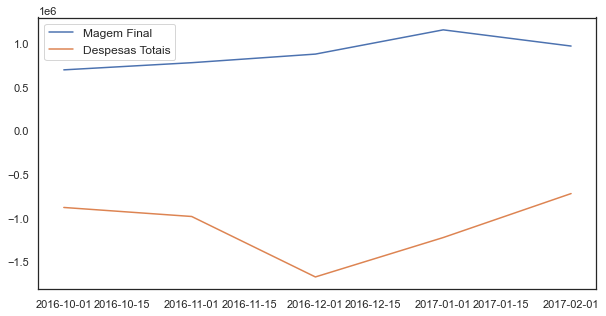

In [570]:
sns.set_style('white')
plt.figure(figsize=(10,5))
plt.plot(df_filtrada['Margem_final'], label='Magem Final')
plt.plot(df_filtrada['Total_1'], label='Despesas Totais')
plt.legend(loc="upper left", fontsize='large')
plt.show()

In [150]:
#preciso deixar 1 linha por cliente 
#teste t / teste de hiposese e analise estatistica da difenreça dos grupos de clientes gerados pela clusterização

In [151]:
df.groupby('Canal')['Margem_final'].mean().sort_values(ascending = False)
#Canal tem uma margem maior de lucro, apesar do custo maior de clientes.

Canal
Canal 1    623.684726
Canal 3    313.087167
Canal 2    215.107302
Name: Margem_final, dtype: float64

In [41]:
df.groupby('Canal')['Nr_cliente'].count().sort_values(ascending = False)

Canal
Canal 3    9879
Canal 1    2042
Canal 2     535
Name: Nr_cliente, dtype: int64

In [152]:
df.groupby('MCC')['Margem_final'].mean().sort_values(ascending = False)
#5655 - RIDING OR SPORTS APPAREL STORES
#5532 - AUTOMOTIVE TIRE STORES
#5013 - MOTOR VEHICLE SUPPLIES AND NEW PARTS
#5085 -INDUSTRIAL SUPPLIES (NEC) 
#0763 - AGRICULTURAL COOPERATIVES
#_____
#5311 - DEPARTMENT STORES
#5065 - ELECTRICAL PARTS AND EQUIPMENT 
#5735 - RECORD SHOPS

MCC
5655    5098.745010
5532    3616.312243
5013    3417.995760
5085    3407.687390
763     2595.570110
           ...     
5309    -150.893643
5111    -154.650125
5735    -156.923563
5065    -289.345485
5311    -540.528818
Name: Margem_final, Length: 190, dtype: float64

In [153]:
df.groupby('Nr_cliente')['Margem_final'].mean().sort_values(ascending = False)

Nr_cliente
100115111135084    95446.688184
100137088762032    32754.206933
100106049346009    18062.219577
100142994328606    15254.803630
100111148789116    10789.981104
                       ...     
100606531143797    -1657.973737
100741097911059    -1780.375841
100903425275804    -1992.158358
100131709300892    -2738.418237
100113076151766    -4282.992946
Name: Margem_final, Length: 3194, dtype: float64

In [154]:
df.groupby('Nr_cliente')['Margem_final'].max().sort_values(ascending = False)

Nr_cliente
100115111135084    122221.850504
100137088762032     90626.282787
100106049346009     48546.605995
100104386304266     23861.345225
100109373275899     21583.033177
                       ...      
100131166280902     -1254.412941
100131709300892     -1367.061159
100606531143797     -1657.973737
100741097911059     -1780.375841
100903425275804     -1992.158358
Name: Margem_final, Length: 3194, dtype: float64

In [155]:
#cliente com a margem mais alta (média e soma)
df.loc[df.Nr_cliente == 100115111135084]

,Nr_cliente,MCC,Data_apuracao,Data_entrada,Canal,Cidade,Volume_transacionado,Qnt_transacoes,Net_MDR,Aluguel,Pre_pagamento,Total,Pre_pagamento_1,Equipamento_Logistica,Comissoes,Transacionais,Outros,Total_1,Margem_final
1808,100115111135084,5499,2016-10-01,2015-07-10,Canal 1,Porto Alegre,4949658.77,23218.0,71689.534250,0.0,123938.59980,195628.134050,-113722.561764,0.0,0.0,-1560.505238,-351.366471,-115634.433473,79993.700577
3261,100115111135084,5499,2016-11-01,2015-07-10,Canal 1,Porto Alegre,4578579.78,25951.0,65556.403375,0.0,109118.10139,174674.504765,-91591.865562,0.0,0.0,-1754.442525,-168.156851,-93514.464938,81160.039827
6705,100115111135084,5499,2016-12-01,2015-07-10,Canal 1,Porto Alegre,5248593.11,29271.0,74714.427125,0.0,269895.05927,344609.486395,-227243.468878,0.0,0.0,-1913.301584,-225.854676,-229382.625139,115226.861256
8648,100115111135084,5499,2017-01-01,2015-07-10,Canal 1,Porto Alegre,5626038.57,32600.0,98896.565625,0.0,151650.78054,250547.346165,-125814.781955,0.0,0.0,-2169.424125,-341.289581,-128325.495661,122221.850504
11452,100115111135084,5499,2017-02-01,2015-07-10,Canal 1,Porto Alegre,3201583.77,19948.0,53042.569062,0.0,89305.09605,142347.665112,-62099.290350,0.0,0.0,-1352.075175,-265.310833,-63716.676358,78630.988755


In [156]:
#Total = Net_MDR + Pre_pagamento
#Total1 = Pre_pagamento_1 + Equipamento_Logistica + Comissões + Transacionais + Outros
#Margem = Total - Total1

#deletar Pre_pagamento_1 + Equipamento_Logistica + Comissões + Transacionais + Outros e TOtal1? evitar ruído

## Preparar o dataset 

### Fazer o Goupby.Mean dos dados para criar uma linha por cliente

In [54]:
df.columns

Index(['Nr_cliente', 'MCC', 'Data_apuracao', 'Data_entrada', 'Canal', 'Cidade',
       'Volume_transacionado', 'Qnt_transacoes', 'Net_MDR', 'Aluguel',
       'Pre_pagamento', 'Total', 'Pre_pagamento_1', 'Equipamento_Logistica',
       'Comissoes', 'Transacionais', 'Outros', 'Total_1', 'Margem_final'],
      dtype='object')

In [66]:
df2 = df.groupby('Nr_cliente')[['Volume_transacionado','Qnt_transacoes','Net_MDR','Aluguel','Pre_pagamento',
                          'Pre_pagamento_1','Equipamento_Logistica','Comissoes','Transacionais','Outros','Margem_final']].mean()
df2
#como sabemos o groupby não aceita features categóricas
#já exclui aqui o Total e Total1

,Volume_transacionado,Qnt_transacoes,Net_MDR,Aluguel,Pre_pagamento,Pre_pagamento_1,Equipamento_Logistica,Comissoes,Transacionais,Outros,Margem_final
Nr_cliente,,,,,,,,,,,
100100026313922,0.000,0.00,0.000000,0.00000,0.000000,0.000000,-13.317332,0.000,0.000000,0.000000,-13.317332
100100082815567,6219.118,64.00,43.270506,46.82700,0.000000,0.000000,-13.600000,-117.975,-8.914328,0.000000,-50.391821
100100087809648,47.000,4.00,0.594625,0.00000,0.000000,0.000000,0.000000,0.000,-0.235950,0.000000,0.358675
100100123542587,60.000,0.50,1.098281,0.00000,0.000000,0.000000,0.000000,0.000,-0.029494,0.000000,1.068787
100100135452383,1808.180,21.80,43.692956,72.60000,27.394055,-8.142508,-14.400000,0.000,-6.061756,-3.827393,111.255355
...,...,...,...,...,...,...,...,...,...,...,...
100998082949562,0.000,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000
100998512060885,19231.800,7.00,137.399200,72.50925,1354.523030,-512.293856,-15.600000,0.000,-1.845855,0.000000,1034.691769
100998549487017,15017.798,343.40,106.649100,71.69250,0.000000,0.000000,-17.759158,0.000,-24.664943,0.000000,135.917500


In [138]:
#agora tenho que incluir as categoricas MCC, Data_entrada, Canal e Cidade

In [138]:
df.groupby(['Nr_cliente','MCC'])['Volume_transacionado'].count()
#podemos ver que para cada cliente temos 1 MCC

Nr_cliente       MCC 
100100026313922  8699    5
100100082815567  5999    5
100100087809648  5499    2
100100123542587  8299    2
100100135452383  5812    5
                        ..
100998082949562  5947    5
100998512060885  5714    5
100998549487017  5912    5
100999120593886  5912    4
100999875040090  8071    1
Name: Volume_transacionado, Length: 3194, dtype: int64

In [125]:
df.groupby(['Nr_cliente','Data_entrada'])['Volume_transacionado'].count()
#podemos ver que para um ou mais clientes temos datas de entrada diferentes..

Nr_cliente       Data_entrada
100100026313922  2015-10-08      5
100100082815567  2016-09-27      5
100100087809648  2016-08-18      2
100100123542587  2016-12-01      2
100100135452383  2015-12-01      5
                                ..
100998082949562  2016-06-29      5
100998512060885  2016-04-14      5
100998549487017  2016-03-16      5
100999120593886  2016-08-02      4
100999875040090  2017-01-04      1
Name: Volume_transacionado, Length: 3212, dtype: int64

In [124]:
df.groupby(['Nr_cliente','Canal'])['Volume_transacionado'].count()
#podemos ver que para um cliente temos canais diferentes..

Nr_cliente       Canal  
100100026313922  Canal 3    5
100100082815567  Canal 3    5
100100087809648  Canal 1    2
100100123542587  Canal 1    2
100100135452383  Canal 3    5
                           ..
100998082949562  Canal 3    5
100998512060885  Canal 3    5
100998549487017  Canal 3    5
100999120593886  Canal 1    4
100999875040090  Canal 1    1
Name: Volume_transacionado, Length: 3195, dtype: int64

In [123]:
df.groupby(['Nr_cliente','Cidade'])['Volume_transacionado'].count()
#podemos ver que para um cliente temos cidades diferentes..

Nr_cliente       Cidade                 
100100026313922  Rio de Janeiro             5
100100082815567  São Bernardo do Campo      5
100100087809648  São Paulo                  2
100100123542587  Jaboatão dos Guararapes    2
100100135452383  Belo Horizonte             5
                                           ..
100998082949562  Niterói                    5
100998512060885  Campinas                   5
100998549487017  São Paulo                  5
100999120593886  Santa Maria                4
100999875040090  Itaporã                    1
Name: Volume_transacionado, Length: 3365, dtype: int64

In [266]:
#vou criar códigos para exlcluir essas linhas de clientes que tem mais de 1 valor diferente para as features categóricas (que deveriam ser iguais)
#criar uma lista com os clientes do dataset para rodar o for
clientes = df['Nr_cliente'].unique().tolist()

In [287]:
cliente_unico_canal = []

for client in clientes:
    lista_canais = df.loc[df.Nr_cliente == client]['Canal'].unique().tolist()
    if len(lista_canais) == 1:
               cliente_unico_canal.append(client)
            
df_canal = df.loc[df.Nr_cliente.isin(cliente_unico_canal)][['Nr_cliente','Canal']]
df_canal = df_canal.drop_duplicates()
lista_canal1 = df_canal.Nr_cliente.tolist()
df_canal.shape

(3193, 2)

In [288]:
cliente_unico_MCC = []

for client in clientes:
    lista_mcc = df.loc[df.Nr_cliente == client]['MCC'].unique().tolist()
    if len(lista_mcc) == 1:
               cliente_unico_MCC.append(client)

df_MCC = df.loc[df.Nr_cliente.isin(cliente_unico_MCC)][['Nr_cliente','MCC']]
df_MCC = df_MCC.drop_duplicates()
lista_mcc1 = df_MCC.Nr_cliente.tolist()
df_MCC.shape

(3194, 2)

In [289]:
cliente_unico_data = []

for client in clientes:
    lista_data = df.loc[df.Nr_cliente == client]['Data_entrada'].unique().tolist()
    if len(lista_data) == 1:
               cliente_unico_data.append(client)

df_data = df.loc[df.Nr_cliente.isin(cliente_unico_data)][['Nr_cliente','Data_entrada']]
df_data = df_data.drop_duplicates()
lista_data1 = df_data.Nr_cliente.tolist()
df_data.shape

(3176, 2)

In [290]:
cliente_unico_cidade = []

for client in clientes:
    lista_cidade = df.loc[df.Nr_cliente == client]['Cidade'].unique().tolist()
    if len(lista_cidade) == 1:
               cliente_unico_cidade.append(client)

df_cidade = df.loc[df.Nr_cliente.isin(cliente_unico_cidade)][['Nr_cliente','Cidade']]
df_cidade = df_cidade.drop_duplicates()
lista_cidade1 = df_cidade.Nr_cliente.tolist()
df_cidade.shape


(3094, 2)

In [291]:
#agora vou rodar um intersection dessas listas até chegar numa comum para todas e criar 1 unica lista com tds clientes que tem 1 valor para cada
#feature categórica
inter1 = list(set(lista_canal1).intersection(set(lista_mcc1)))
inter2 = list(set(inter1).intersection(set(lista_data1)))
clientes_unicos_final = list(set(inter2).intersection(set(lista_cidade1)))
len(clientes_unicos_final)
#então temos 3078 clientes para usar no nosso dataset final

3078

In [292]:
#agora vou começar a montar o dataset
#primeiro vou criar um dataframe com os dados originais só que apenas com meus cliente unicos finais
df_unico = df.loc[df.Nr_cliente.isin(clientes_unicos_final)]
len(df_unico.Nr_cliente.unique())

3078

In [293]:
#agora vou fazer o mesmo que fiz ateriormente, mas para esse dataframe unico usando o groupby e o mean
df3 = df_unico.groupby('Nr_cliente')[['Volume_transacionado','Qnt_transacoes','Net_MDR','Aluguel','Pre_pagamento',
                          'Pre_pagamento_1','Equipamento_Logistica','Comissoes','Transacionais','Outros','Margem_final']].mean()
    
df3.reset_index(inplace=True)
df3

,Nr_cliente,Volume_transacionado,Qnt_transacoes,Net_MDR,Aluguel,Pre_pagamento,Pre_pagamento_1,Equipamento_Logistica,Comissoes,Transacionais,Outros,Margem_final
0,100100026313922,0.000,0.00,0.000000,0.00000,0.000000,0.000000,-13.317332,0.000,0.000000,0.000000,-13.317332
1,100100082815567,6219.118,64.00,43.270506,46.82700,0.000000,0.000000,-13.600000,-117.975,-8.914328,0.000000,-50.391821
2,100100087809648,47.000,4.00,0.594625,0.00000,0.000000,0.000000,0.000000,0.000,-0.235950,0.000000,0.358675
3,100100123542587,60.000,0.50,1.098281,0.00000,0.000000,0.000000,0.000000,0.000,-0.029494,0.000000,1.068787
4,100100135452383,1808.180,21.80,43.692956,72.60000,27.394055,-8.142508,-14.400000,0.000,-6.061756,-3.827393,111.255355
...,...,...,...,...,...,...,...,...,...,...,...,...
3073,100998082949562,0.000,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000
3074,100998512060885,19231.800,7.00,137.399200,72.50925,1354.523030,-512.293856,-15.600000,0.000,-1.845855,0.000000,1034.691769
3075,100998549487017,15017.798,343.40,106.649100,71.69250,0.000000,0.000000,-17.759158,0.000,-24.664943,0.000000,135.917500
3076,100999120593886,44.450,0.75,0.519742,0.00000,0.000000,0.000000,0.000000,0.000,-0.332372,0.000000,0.187370


In [294]:
#vou fazer o msm que fiz para o dataframe original para os dataframes que criei para cada feature categorica 
df_mcc_final = df_MCC.loc[df_MCC.Nr_cliente.isin(clientes_unicos_final)]
df_canal_final = df_canal.loc[df_canal.Nr_cliente.isin(clientes_unicos_final)]
df_data_final = df_data.loc[df_data.Nr_cliente.isin(clientes_unicos_final)]
df_cidade_final = df_cidade.loc[df_cidade.Nr_cliente.isin(clientes_unicos_final)]

#e agora para criar o dataframe final preciso dar um merge em tds dfs criados
merge1 = df3.merge(df_mcc_final, on='Nr_cliente')
merge2 = merge1.merge(df_canal_final, on='Nr_cliente')
merge3 = merge2.merge(df_data_final, on='Nr_cliente')
df_final = merge3.merge(df_cidade_final, on='Nr_cliente')
df_final

,Nr_cliente,Volume_transacionado,Qnt_transacoes,Net_MDR,Aluguel,Pre_pagamento,Pre_pagamento_1,Equipamento_Logistica,Comissoes,Transacionais,Outros,Margem_final,MCC,Canal,Data_entrada,Cidade
0,100100026313922,0.000,0.00,0.000000,0.00000,0.000000,0.000000,-13.317332,0.000,0.000000,0.000000,-13.317332,8699,Canal 3,2015-10-08,Rio de Janeiro
1,100100082815567,6219.118,64.00,43.270506,46.82700,0.000000,0.000000,-13.600000,-117.975,-8.914328,0.000000,-50.391821,5999,Canal 3,2016-09-27,São Bernardo do Campo
2,100100087809648,47.000,4.00,0.594625,0.00000,0.000000,0.000000,0.000000,0.000,-0.235950,0.000000,0.358675,5499,Canal 1,2016-08-18,São Paulo
3,100100123542587,60.000,0.50,1.098281,0.00000,0.000000,0.000000,0.000000,0.000,-0.029494,0.000000,1.068787,8299,Canal 1,2016-12-01,Jaboatão dos Guararapes
4,100100135452383,1808.180,21.80,43.692956,72.60000,27.394055,-8.142508,-14.400000,0.000,-6.061756,-3.827393,111.255355,5812,Canal 3,2015-12-01,Belo Horizonte
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3073,100998082949562,0.000,0.00,0.000000,0.00000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,5947,Canal 3,2016-06-29,Niterói
3074,100998512060885,19231.800,7.00,137.399200,72.50925,1354.523030,-512.293856,-15.600000,0.000,-1.845855,0.000000,1034.691769,5714,Canal 3,2016-04-14,Campinas
3075,100998549487017,15017.798,343.40,106.649100,71.69250,0.000000,0.000000,-17.759158,0.000,-24.664943,0.000000,135.917500,5912,Canal 3,2016-03-16,São Paulo
3076,100999120593886,44.450,0.75,0.519742,0.00000,0.000000,0.000000,0.000000,0.000,-0.332372,0.000000,0.187370,5912,Canal 1,2016-08-02,Santa Maria


### Modo 2 de preparar o dataset - cliente por linha

In [67]:
#transformar cada cliente em 1 linha
#manter features = MCC, Data_entrada, Canal, Cidade
#deletar data de apuração (que vai ser o sufixo das features abaixo)
#variar com o mes e criar uma coluna para cada mes:
#Volume_transacionado_Outubro (Novembro, Dezembro, Janeiro, Fevereiro)
#Qnt_transações_Outubro (Novembro, Dezembro, Janeiro, Fevereiro)
#...
#Criar uma margem_final_total = soma de tds as margens

In [83]:
#df.loc[(df.Data_apuracao == '2016-10-01')].count()
#Data de apuração outubro = 2294 linhas
rows1 = 2294

#df.loc[(df.Data_apuracao == '2016-11-01')].count()
#Data de apuração outubro = 2426 linhas
rows2 = rows1 + 2426

#df.loc[(df.Data_apuracao == '2016-12-01')].count()
#Data de apuração outubro = 2521 linhas
rows3 = rows2 + 2521

#df.loc[(df.Data_apuracao == '2017-01-01')].count()
#Data de apuração outubro = 2590 linhas
rows4 = rows3 + 2590

#df.loc[(d.Data_apuracao == '2017-02-01')].count()
#Data de apuração outubro = 2625 linhas
rows5 = rows4 + 2625

In [84]:
#cofirmação
df.shape[0] == rows5

True

In [85]:
df_out = df.loc[(df.index>=0) & (df.index<rows1)]
df_out = df_out.set_index('Nr_cliente')
del df_out['Data_apuracao']
df_out = df_out.add_suffix('_outubro')
df_out.shape

(2294, 19)

In [86]:
df_out = df.loc[(df.index>=0) & (df.index<rows1)]
df_out = df_out.set_index('Nr_cliente')
del df_out['Data_apuracao']
df_out = df_out.add_suffix('_outubro')
df_out.shape

(2294, 19)

In [87]:
df_nov = df.loc[(df.index>=rows1) & (df.index<rows2)]
df_nov = df_nov.set_index('Nr_cliente')
del df_nov['Data_apuracao']
df_nov = df_nov.add_suffix('_novembro')
df_nov.shape

(2426, 19)

In [88]:
df_dez = df.loc[(df.index>=rows2) & (df.index<rows3)]
df_dez = df_dez.set_index('Nr_cliente')
del df_dez['Data_apuracao']
df_dez = df_dez.add_suffix('_dezembro')
df_dez.shape

(2521, 19)

In [89]:
df_jan = df.loc[(df.index>=rows3) & (df.index<rows4)]
df_jan = df_jan.set_index('Nr_cliente')
del df_jan['Data_apuracao']
df_jan = df_jan.add_suffix('_janeiro')
df_jan.shape

(2590, 19)

In [90]:
df_fev = df.loc[(df.index>=rows4) & (df.index<rows5)]
df_fev = df_fev.set_index('Nr_cliente')
del df_fev['Data_apuracao']
df_fev = df_fev.add_suffix('_fevereiro')
df_fev.shape

(2625, 19)

In [91]:
df_concat = pd.concat([df_out, df_nov, df_dez, df_jan, df_fev], axis=1)
df_concat.shape 

(3194, 95)

In [92]:
del df_concat['Data_entrada_outubro']
del df_concat['Data_entrada_novembro']
del df_concat['Data_entrada_dezembro']
del df_concat['Data_entrada_janeiro']
del df_concat['Data_entrada_fevereiro']

del df_concat['MCC_outubro']
del df_concat['MCC_novembro']
del df_concat['MCC_dezembro']
del df_concat['MCC_janeiro']
del df_concat['MCC_fevereiro']


del df_concat['Canal_outubro']
del df_concat['Canal_novembro']
del df_concat['Canal_dezembro']
del df_concat['Canal_janeiro']
del df_concat['Canal_fevereiro']

del df_concat['Cidade_outubro']
del df_concat['Cidade_novembro']
del df_concat['Cidade_dezembro']
del df_concat['Cidade_janeiro']
del df_concat['Cidade_fevereiro']
#df_final.columns

In [94]:
df_concat = df_concat.fillna(0)
df_concat
#como lidar com os NaNs?

,Volume_transacionado_outubro,Qnt_transacoes_outubro,Net_MDR_outubro,Aluguel_outubro,Pre_pagamento_outubro,Total_outubro,Pre_pagamento_1_outubro,Equipamento_Logistica_outubro,Comissoes_outubro,Transacionais_outubro,...,Total_fevereiro,Pre_pagamento_1_fevereiro,Equipamento_Logistica_fevereiro,Comissoes_fevereiro,Transacionais_fevereiro,Outros_fevereiro,Total_1_fevereiro,Margem_final_fevereiro,MCC_cat_fevereiro,Cidade_cat_fevereiro
Nr_cliente,,,,,,,,,,,,,,,,,,,,,
100100026313922,0.00,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,-13.469108,0.00,0.000000,...,0.000000,0.000000,-13.0,0.0,0.000000,0.0,-13.000000,-13.000000,183.0,263.0
100100082815567,8193.69,82.0,55.912500,0.00000,0.000000,55.912500,0.000000,-12.000000,-272.25,-9.737475,...,126.630313,0.000000,-12.0,0.0,-3.475725,0.0,-15.475725,111.154588,115.0,293.0
100100087809648,94.00,8.0,1.189250,0.00000,0.000000,1.189250,0.000000,0.000000,0.00,-0.471900,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0
100100123542587,0.00,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,2.196562,0.000000,0.0,0.0,-0.058987,0.0,-0.058987,2.137575,178.0,146.0
100100135452383,1472.50,18.0,34.026750,72.60000,33.658550,140.285300,-9.524275,-12.000000,0.00,-4.873275,...,180.120139,-10.648948,-11.0,0.0,-5.367863,0.0,-27.016811,153.103328,86.0,36.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100998082949562,0.00,0.0,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.00,0.000000,...,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,99.0,196.0
100998512060885,35277.00,9.0,248.136125,72.50925,2963.888005,3284.533380,-1112.073468,-16.000000,0.00,-2.060025,...,1356.945235,-356.704949,-16.0,0.0,-2.854087,0.0,-375.559036,981.386199,78.0,56.0
100998549487017,16045.31,367.0,109.668375,71.69250,0.000000,181.360875,0.000000,-18.795788,0.00,-26.176838,...,161.984531,0.000000,-19.0,0.0,-20.191875,0.0,-39.191875,122.792656,89.0,308.0


In [126]:
df_concat["Margem_Total"] = df_concat['Margem_final_outubro'] + df_concat['Margem_final_novembro'] + \
df_concat['Margem_final_dezembro'] + df_concat['Margem_final_janeiro'] + df_concat['Margem_final_fevereiro']

In [127]:
df_concat['Margem_Total'].sum()

4481634.741928061

In [ ]:
#não vou fazer dessa maneira (vou usar o df_final do modo 1)... criaou mtas features
#ainda precisaria colocar as features categoricas
#poderia ser interessante rodar uma clusterização por mes e ver como o comportamente dos classes de clientes/cada cliente variam com o mês

## Churn - conjunto inteiro de dados dos clientes

In [52]:
#vou usar o df original
df_churn = df.pivot_table(index='Nr_cliente', columns='Data_apuracao', values='Qnt_transacoes', aggfunc='count', fill_value=0).head(10)
df_churn

Data_apuracao,2016-10-01,2016-11-01,2016-12-01,2017-01-01,2017-02-01
Nr_cliente,,,,,
100100026313922,1,1,1,1,1
100100082815567,1,1,1,1,1
100100087809648,1,1,0,0,0
100100123542587,0,0,1,0,1
100100135452383,1,1,1,1,1
100100227947880,0,0,0,1,1
100100274300101,1,1,1,1,1
100100275393609,1,1,1,1,1
100100277425335,1,1,1,1,1


In [ ]:
# aqui podemos observar como funiona um churn do cliente

In [42]:
#vou criar um df para cada mes com os clientes que fizeram transações (se mantiveram ativos) e que não fizeram transações (inativos) para cada mês
df_out_ativo = df.loc[(df.Data_apuracao == '2016-10-01') & (df.Qnt_transacoes != 0)]
df_out_inativo = df.loc[(df.Data_apuracao == '2016-10-01') & (df.Qnt_transacoes == 0)]

df_nov_ativo = df.loc[(df.Data_apuracao == '2016-11-01') & (df.Qnt_transacoes != 0)]
df_nov_inativo = df.loc[(df.Data_apuracao == '2016-11-01') & (df.Qnt_transacoes == 0)]

df_dez_ativo = df.loc[(df.Data_apuracao == '2016-12-01') & (df.Qnt_transacoes != 0)]
df_dez_inativo = df.loc[(df.Data_apuracao == '2016-12-01') & (df.Qnt_transacoes == 0)]

df_jan_ativo = df.loc[(df.Data_apuracao == '2017-01-01') & (df.Qnt_transacoes != 0)]
df_jan_inativo = df.loc[(df.Data_apuracao == '2017-01-01') & (df.Qnt_transacoes == 0)]

df_fev_ativo = df.loc[(df.Data_apuracao == '2017-02-01') & (df.Qnt_transacoes != 0)]
df_fev_inativo = df.loc[(df.Data_apuracao == '2017-02-01') & (df.Qnt_transacoes == 0)]

In [139]:
#Churn Novembro
#vou criar uma lista com esses clientes ativos e inativos de cada mes
lista_clientes_out_ativo = df_out_ativo['Nr_cliente'].tolist()
lista_clientes_nov_inativo = df_nov_inativo['Nr_cliente'].tolist()

#vou fazer uma intersecção das listas dos clientes que estavam ativos no mes anterior, mas que no mes atual ficaram inativos e criar uma outra lista
#desses clientes especificos
lista_churn_novembro = list(set(lista_clientes_out_ativo).intersection(set(lista_clientes_nov_inativo)))
taxa_churn_novembro = len(lista_churn_novembro)/len(df_out_ativo)


print("Nr Churn em Novembro: " + str(len(lista_churn_novembro)))
print("Taxa de Churn em Novembro: " + (str(round(taxa_churn_novembro*100,2)) + '%'))
print("Tempo de vida médio: " + str(round(1/taxa_churn_novembro,1)))

Nr Churn em Novembro: 105
Taxa de Churn em Novembro: 6.11%
Tempo de vida médio: 16.4


In [140]:
#Churn Dezembro
lista_clientes_nov_ativo = df_nov_ativo['Nr_cliente'].tolist()
lista_clientes_dez_inativo = df_dez_inativo['Nr_cliente'].tolist()

lista_churn_dezembro = list(set(lista_clientes_nov_ativo).intersection(set(lista_clientes_dez_inativo)))
taxa_churn_dezembro = len(lista_churn_dezembro)/len(df_nov_ativo)


print("Nr Churn em Dezembro: " + str(len(lista_churn_dezembro)))
print("Taxa de Churn em Dezembro: " + (str(round(taxa_churn_dezembro*100,2)) + '%'))
print("Tempo de vida médio: " + str(round(1/taxa_churn_dezembro,1)))

Nr Churn em Dezembro: 108
Taxa de Churn em Dezembro: 5.75%
Tempo de vida médio: 17.4


In [141]:
#Churn Janeiro
lista_clientes_dez_ativo = df_dez_ativo['Nr_cliente'].tolist()
lista_clientes_jan_inativo = df_jan_inativo['Nr_cliente'].tolist()

lista_churn_janeiro = list(set(lista_clientes_dez_ativo).intersection(set(lista_clientes_jan_inativo)))
taxa_churn_janeiro = len(lista_churn_janeiro)/len(df_dez_ativo)


print("Nr Churn em Janeiro: " + str(len(lista_churn_janeiro)))
print("Taxa de Churn em Janeiro: " + (str(round(taxa_churn_janeiro*100,2)) + '%'))
print("Tempo de vida médio: " + str(round(1/taxa_churn_janeiro,1)))

Nr Churn em Janeiro: 138
Taxa de Churn em Janeiro: 6.91%
Tempo de vida médio: 14.5


In [142]:
#Churn Fevereiro
lista_clientes_jan_ativo = df_jan_ativo['Nr_cliente'].tolist()
lista_clientes_fev_inativo = df_fev_inativo['Nr_cliente'].tolist()

lista_churn_fevereiro = list(set(lista_clientes_jan_ativo).intersection(set(lista_clientes_fev_inativo)))
taxa_churn_fevereiro = len(lista_churn_fevereiro)/len(df_jan_ativo)


print("Nr Churn em Fevereiro: " + str(len(lista_churn_fevereiro)))
print("Taxa de Churn em Fevereiro: " + (str(round(taxa_churn_fevereiro*100,2)) + '%'))
print("Tempo de vida médio: " + str(round(1/taxa_churn_fevereiro,1)))

Nr Churn em Fevereiro: 108
Taxa de Churn em Fevereiro: 5.33%
Tempo de vida médio: 18.8


In [295]:
#agora vou criar uma coluna Churn para aqueles clientes que deram churn em algum momento 
uniao1 = list(set(lista_churn_novembro).union(set(lista_churn_dezembro)))
uniao2 = list(set(uniao1).union(set(lista_churn_janeiro)))
lista_final_churn = list(set(uniao2).union(set(lista_churn_fevereiro)))

In [296]:
len(lista_final_churn)
#436 clientes em algum momento deram um churn

436

In [297]:
df_final['Churn'] = np.where(df_final['Nr_cliente'].isin(lista_final_churn), 1, 0)
df_final.head()

,Nr_cliente,Volume_transacionado,Qnt_transacoes,Net_MDR,Aluguel,Pre_pagamento,Pre_pagamento_1,Equipamento_Logistica,Comissoes,Transacionais,Outros,Margem_final,MCC,Canal,Data_entrada,Cidade,Churn
0,100100026313922,0.000,0.0,0.000000,0.000,0.000000,0.000000,-13.317332,0.000,0.000000,0.000000,-13.317332,8699,Canal 3,2015-10-08,Rio de Janeiro,0
1,100100082815567,6219.118,64.0,43.270506,46.827,0.000000,0.000000,-13.600000,-117.975,-8.914328,0.000000,-50.391821,5999,Canal 3,2016-09-27,São Bernardo do Campo,0
2,100100087809648,47.000,4.0,0.594625,0.000,0.000000,0.000000,0.000000,0.000,-0.235950,0.000000,0.358675,5499,Canal 1,2016-08-18,São Paulo,1
3,100100123542587,60.000,0.5,1.098281,0.000,0.000000,0.000000,0.000000,0.000,-0.029494,0.000000,1.068787,8299,Canal 1,2016-12-01,Jaboatão dos Guararapes,0
4,100100135452383,1808.180,21.8,43.692956,72.600,27.394055,-8.142508,-14.400000,0.000,-6.061756,-3.827393,111.255355,5812,Canal 3,2015-12-01,Belo Horizonte,0


# Clusterização

## K-Means

In [298]:
#preciso transformar as categóricas
dummies = ['Canal']
categoricas = ['MCC','Cidade']


df_clust = pd.get_dummies(df_final, columns = dummies)

In [299]:
df_clust['Data_entrada']=pd.to_datetime(df_clust['Data_entrada'], errors='coerce')

In [300]:
df_clust["Dia"] = df_clust['Data_entrada'].map(lambda x: x.day)
df_clust["Mes"] = df_clust['Data_entrada'].map(lambda
                                             x: x.month)
df_clust["Ano"] = df_clust['Data_entrada'].map(lambda x: x.year)
del df_clust['Data_entrada']

In [301]:
df_clust.isnull().sum()

Nr_cliente               0
Volume_transacionado     0
Qnt_transacoes           0
Net_MDR                  0
Aluguel                  0
Pre_pagamento            0
Pre_pagamento_1          0
Equipamento_Logistica    0
Comissoes                0
Transacionais            0
Outros                   0
Margem_final             0
MCC                      0
Cidade                   0
Churn                    0
Canal_Canal 1            0
Canal_Canal 2            0
Canal_Canal 3            0
Dia                      0
Mes                      0
Ano                      0
dtype: int64

In [302]:
df_clust = df_clust.fillna(0)

In [303]:
X = df_clust

In [304]:
encoder = CountFrequencyEncoder(encoding_method='frequency',
                         variables=categoricas)
#
##treinar o encoder
encoder.fit(X)
#
##transformar os dados
X = encoder.transform(X)

In [305]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

1 64638.00000000011
2 57900.358196135116
3 47486.14698016844
4 43835.019727089144
5 41851.08572252401
6 38346.93047180493
7 36387.073822784
8 34772.445615362645
9 33635.13249995254
10 31072.350681697626


Text(0, 0.5, 'WSS')

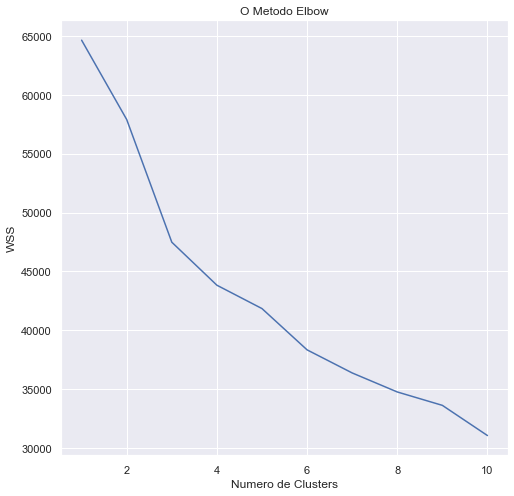

In [306]:
## Vou utilizar o K-Means a principio
#primeiro vou identificar o nr correto de cluesters

plt.figure(figsize=(8,8))

# plotando o gráfico do método elbow
wcss = []
 
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'random')
    kmeans.fit(X)
    print (i,kmeans.inertia_)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('O Metodo Elbow')
plt.xlabel('Numero de Clusters')
plt.ylabel('WSS') #within cluster sum of squares

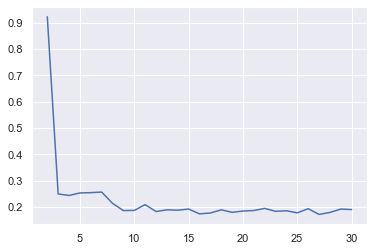

In [307]:
sillhoute_scores = []
n_cluster_list = np.arange(2,31).astype(int)

for n_cluster in n_cluster_list:
    kmeans = KMeans(n_clusters=n_cluster)
    cluster_found = kmeans.fit_predict(X)
    sillhoute_scores.append(silhouette_score(X, kmeans.labels_))
    
plt.plot(n_cluster_list,sillhoute_scores)

In [308]:
# utilizando o K-Means com 3 clusters
kmeans = KMeans(n_clusters = 3, n_init=25, max_iter = 600, random_state=0).fit(X)
labels = kmeans.predict(X)
C = kmeans.cluster_centers_

In [309]:
df_final['labels'] = labels

In [312]:
cluster_1 = df_final.loc[df_final.labels == 0]
cluster_2 = df_final.loc[df_final.labels == 1]
cluster_3 = df_final.loc[df_final.labels == 2]

In [355]:
EDA(cluster_1)
#agora preciso fazer uma analise da margem total, custo total, churn e tempo de vida medio para cada um g1 e g0 e comparar
#fazer o churn para cada cluster e analisar

<ipython-input-354-e49650dc6efa>:50: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  eda_df['Mean'] = df.mean().round(3)


,Amount_NaN,%_NaN,DType,Amount_Data,Amount_Unique,Min,Max,Mean,Normality,Amount_Outliers,%_Outliers
nr_cliente,0,0.0,int64,2341,2341,100100026313922,100998549487017,1.002294e+14,not_applicable,374.0,0.16
volume_transacionado,0,0.0,float64,2341,1964,0.0,1051399.856,2.381112e+04,not_applicable,241.0,0.10
qnt_transacoes,0,0.0,float64,2341,1310,0.0,14483.5,2.801860e+02,not_applicable,294.0,0.13
net_mdr,0,0.0,float64,2341,1962,-85.401906,7252.910481,1.662520e+02,not_applicable,226.0,0.10
aluguel,0,0.0,float64,2341,836,0.0,1562.46816,5.218900e+01,not_applicable,67.0,0.03
pre_pagamento,0,0.0,float64,2341,1105,0.0,17815.663122,2.656860e+02,not_applicable,382.0,0.16
pre_pagamento_1,0,0.0,float64,2341,1107,-9108.61617,0.0,-1.171500e+02,not_applicable,395.0,0.17
equipamento_logistica,0,0.0,float64,2341,1676,-413.34107,0.0,-2.983600e+01,not_applicable,221.0,0.09
comissoes,0,0.0,float64,2341,80,-1815.0,0.0,-3.435700e+01,not_applicable,336.0,0.14
transacionais,0,0.0,float64,2341,1920,-875.769262,0.0,-2.093400e+01,not_applicable,223.0,0.10


In [314]:
EDA(cluster_2)

,Amount_NaN,%_NaN,DType,Amount_Data,Amount_Unique,Min,Max,Normality,Amount_Outliers,%_Outliers
nr_cliente,0,0.0,int64,5,5,100104386304266,100137088762032,not_applicable,0.0,0.0
volume_transacionado,0,0.0,float64,5,5,4216916.4412,7442731.344,not_applicable,0.0,0.0
qnt_transacoes,0,0.0,float64,5,5,5091.2,73568.6,not_applicable,0.0,0.0
net_mdr,0,0.0,float64,5,5,1261.248881,72779.899887,not_applicable,1.0,0.2
aluguel,0,0.0,float64,5,2,0.0,753.353865,not_applicable,NaN,NaN
pre_pagamento,0,0.0,float64,5,4,0.0,148781.52741,not_applicable,0.0,0.0
pre_pagamento_1,0,0.0,float64,5,4,-150046.786366,0.0,not_applicable,0.0,0.0
equipamento_logistica,0,0.0,float64,5,2,-343.887724,0.0,not_applicable,NaN,NaN
comissoes,0,0.0,float64,5,1,0.0,0.0,not_applicable,NaN,NaN
transacionais,0,0.0,float64,5,5,-5890.510382,-314.179459,not_applicable,0.0,0.0


In [315]:
EDA(cluster_3)

,Amount_NaN,%_NaN,DType,Amount_Data,Amount_Unique,Min,Max,Normality,Amount_Outliers,%_Outliers
nr_cliente,0,0.0,int64,732,732,100100087809648,100999875040090,not_applicable,108.0,0.15
volume_transacionado,0,0.0,float64,732,424,0.0,3127805.512,not_applicable,133.0,0.18
qnt_transacoes,0,0.0,float64,732,310,0.0,35512.2,not_applicable,124.0,0.17
net_mdr,0,0.0,float64,732,429,-1062.194612,6088.704844,not_applicable,148.0,0.20
aluguel,0,0.0,float64,732,55,0.0,417.45,not_applicable,67.0,0.09
pre_pagamento,0,0.0,float64,732,90,0.0,42012.25885,not_applicable,89.0,0.12
pre_pagamento_1,0,0.0,float64,732,90,-36765.798153,0.0,not_applicable,89.0,0.12
equipamento_logistica,0,0.0,float64,732,99,-209.998986,0.0,not_applicable,110.0,0.15
comissoes,0,0.0,float64,732,1,0.0,0.0,not_applicable,NaN,NaN
transacionais,0,0.0,float64,732,402,-2103.04776,0.0,not_applicable,119.0,0.16


1 - Utilizando alguma técnica de clusterização da sua escolha, identifique diferentes perfis de clientes, 
apontando, para cada grupo: a receita, o custo, o lucro, índice de evasão e tempo de vida médio. 
Como você descreveria qualitativamente os perfis traçados? 
(Ex. "Clientes de alto faturamento", "Clientes do ramo de alimentação" etc.).

In [347]:
#Receita média
#Total = Net_MDR + Pre_pagamento
#Total1 = Pre_pagamento_1 + Equipamento_Logistica + Comissões + Transacionais + Outros
#Margem = Total - Total1

net_mdr_1 = cluster_1['Net_MDR'].mean()
pre_pag_1 = cluster_1['Pre_pagamento'].mean()
receita_media_1 = net_mdr_1 + pre_pag_1

pre_pag_11 = cluster_1['Pre_pagamento_1'].mean()
equip_log_1 = cluster_1['Equipamento_Logistica'].mean()
com_1 = cluster_1['Comissoes'].mean()
trans_1 = cluster_1['Transacionais'].mean()
outros_1 = cluster_1['Outros'].mean()
custo_1 = pre_pag_11 + equip_log_1 + com_1 + trans_1 + outros_1

lucro_1 = receita_media_1 - custo_1

#____

net_mdr_2 = cluster_2['Net_MDR'].mean()
pre_pag_2 = cluster_2['Pre_pagamento'].mean()
receita_media_2 = net_mdr_2 + pre_pag_2

pre_pag_12 = cluster_2['Pre_pagamento_1'].mean()
equip_log_2 = cluster_2['Equipamento_Logistica'].mean()
com_2 = cluster_2['Comissoes'].mean()
trans_2 = cluster_2['Transacionais'].mean()
outros_2 = cluster_2['Outros'].mean()
custo_2 = pre_pag_12 + equip_log_2 + com_2 + trans_2 + outros_2

lucro_2 = receita_media_2 - custo_2

#___

net_mdr_3 = cluster_3['Net_MDR'].mean()
pre_pag_3 = cluster_3['Pre_pagamento'].mean()
receita_media_3 = net_mdr_3 + pre_pag_3

pre_pag_13 = cluster_3['Pre_pagamento_1'].mean()
equip_log_3 = cluster_3['Equipamento_Logistica'].mean()
com_3 = cluster_3['Comissoes'].mean()
trans_3 = cluster_3['Transacionais'].mean()
outros_3 = cluster_3['Outros'].mean()
custo_3 = pre_pag_13 + equip_log_3 + com_3 + trans_3 + outros_3

lucro_3 = receita_media_3 - custo_3

In [358]:
receita = {'Receita Cluster 1': receita_media_1,
        'Receita Cluster 2': receita_media_2,
         'Receita Cluster 3': receita_media_3
        }

custo = {'Custo Cluster 1': custo_1,
        'Custo 2': custo_2,
         'Custo Cluster 3': custo_3
        }

lucro = {'Lucro Cluster 1': lucro_1,
        'Lucro Cluster 2': lucro_2,
         'Lucro Cluster 3': lucro_3
        }

In [357]:
print(net_mdr_1)
print(net_mdr_2)
print(net_mdr_3)

166.25161852640431
20313.269893999997
135.37455065500686


431.93778853971776
104697.72874082
424.2615637703302


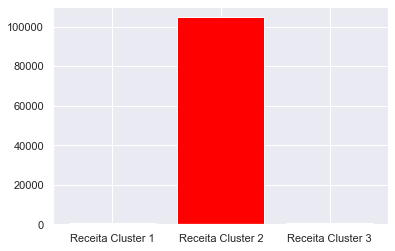

In [362]:
print(receita_media_1)
print(receita_media_2)
print(receita_media_3)

plt.bar(*zip(*receita.items()), color='red')
plt.show()

-222.0323713663428
-78688.03512168574
-271.32427303895264


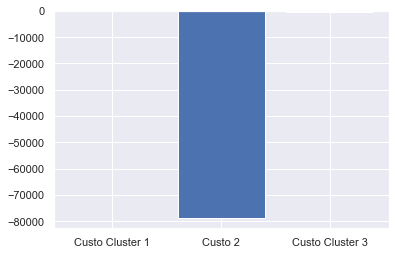

In [360]:
print(custo_1)
print(custo_2)
print(custo_3)

plt.bar(*zip(*custo.items()))
plt.show()

653.9701599060605
183385.76386250573
695.5858368092829


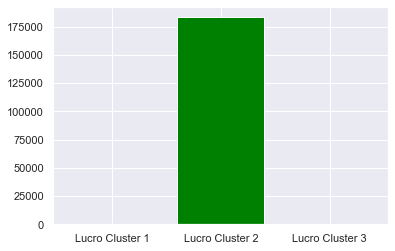

In [363]:
print(lucro_1)
print(lucro_2)
print(lucro_3)

plt.bar(*zip(*lucro.items()), color='green')
plt.show()

In [ ]:
#podemos perceber que o cluster 2, tem clientes outliers altamente lucrativos (com receitas e custos muito maiores)

###  Distribuição da margem final dos clientes de cada cluster

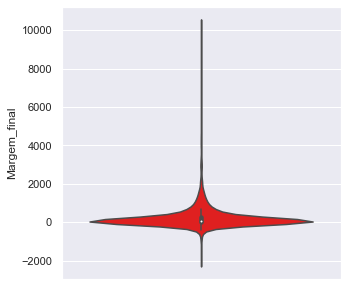

In [364]:
plt.figure(figsize=(5,5))
sns.violinplot(y='Margem_final',data=cluster_1, color='red')
plt.show()

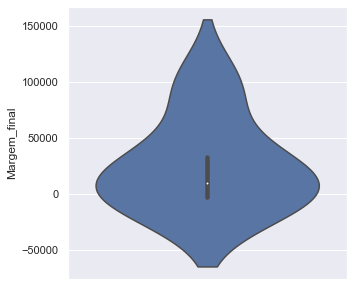

In [326]:
plt.figure(figsize=(5,5))
sns.violinplot(y='Margem_final',data=cluster_2)
plt.show()

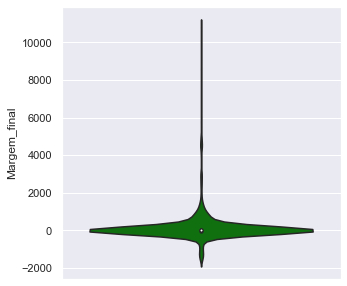

In [365]:
plt.figure(figsize=(5,5))
sns.violinplot(y='Margem_final',data=cluster_3, color='green')
plt.show()

### Porcentagem de clientes que deram Churn em cada cluster

In [329]:
print("Churn Cluster 1: " + str(cluster_1['Churn'].mean()))
print("Churn Cluster 2: " + str(cluster_2['Churn'].mean()))
print("Churn Cluster 3: " + str(cluster_3['Churn'].mean()))

Churn Cluster 1: 0.13242204186245193
Churn Cluster 2: 0.0
Churn Cluster 3: 0.15437158469945356


### Clientes de quais Canais de Venda

Canal 3    2337
Canal 2       3
Canal 1       1
Name: Canal, dtype: int64


<AxesSubplot:>

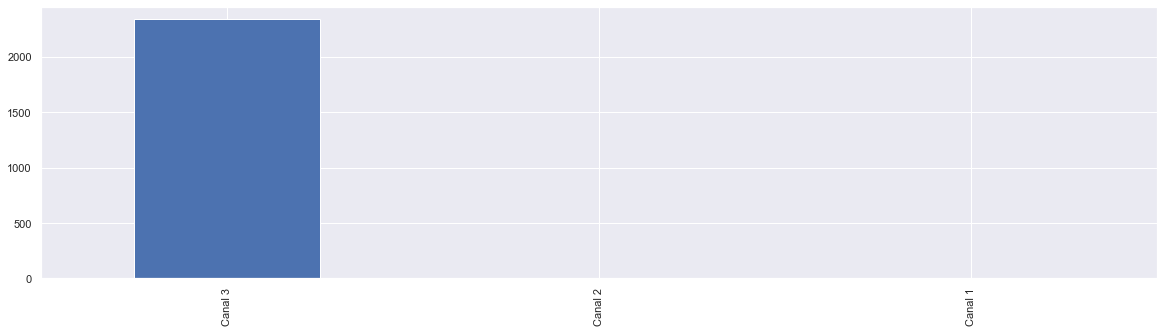

In [340]:
print(cluster_1.Canal.value_counts())
cluster_1.Canal.value_counts().plot.bar(figsize=(20,5))

Canal 1    4
Canal 2    1
Name: Canal, dtype: int64


<AxesSubplot:>

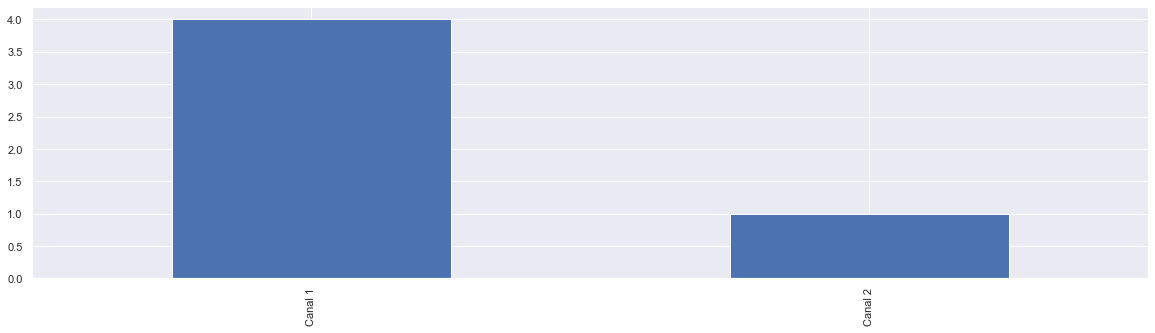

In [341]:
print(cluster_2.Canal.value_counts())
cluster_2.Canal.value_counts().plot.bar(figsize=(20,5))

Canal 1    622
Canal 2    110
Name: Canal, dtype: int64


<AxesSubplot:>

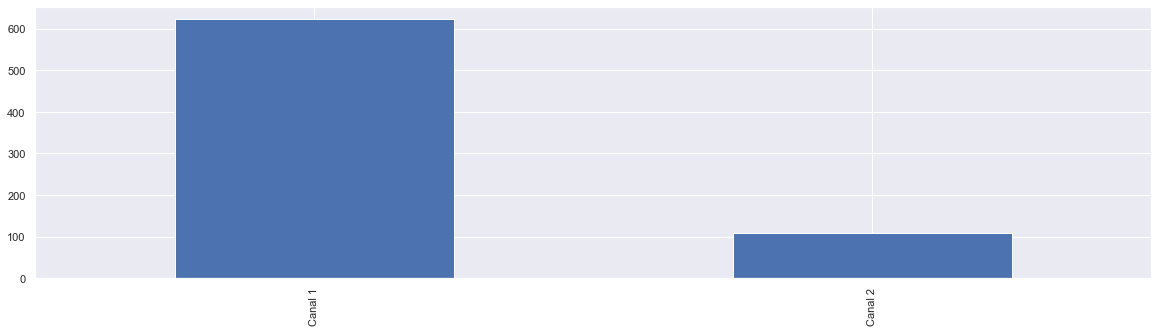

In [342]:
print(cluster_3.Canal.value_counts())
cluster_3.Canal.value_counts().plot.bar(figsize=(20,5))

In [ ]:
#claramente a separação foi pelo canal de venda
#custo de aquisição do cliente pelo canal 1 e 2 é mais cara que pelo canal 3

2 - Assumindo que o custo da atividade comercial (campanhas de marketing, comissão de vendedores) 
para adquirir um novo cliente varie unicamente com o "canal", quais perfis de cliente você indicaria
a empresa ter mais foco em vendas (novos clientes), visando o resultado de longo prazo? 
Consequentemente, em qual o "canal" devemos focar (escolha um)?

In [453]:
df_final.Canal.value_counts()

Canal 3    2337
Canal 1     627
Canal 2     114
Name: Canal, dtype: int64

In [ ]:
# Canal 3 é o canal com menor custo de aquisição de clientes, e já é um canal mto forte de vendas com 75% dos clientes
# pensando unicamente nessa questão de custo comercial, indicaria que a empresa focasse seus esforços na prospecção de clients dcom o perfil
#presentes no cluster 1

In [456]:
cluster_1.groupby('MCC')['Margem_final'].mean().sort_values(ascending = False)

#5 setores com maior margem de lucro do cluster 1 

#5013 - MOTOR VEHICLE SUPPLIES AND NEW PARTS
#7623 - AIR CONDITIONING OR REFRIGERATION REPAIR SHOPS
#5044 - PHOTOGRAPHIC, PHOTOCOPY, MICROFILM EQUIPMENT AND SUPPLIES
#5511 - AUTO/TRUCK DEALERS NEW/USED SALE REPAIR PARTS & LEASE
#4411 - CRUISE OR STEAMSHIP LINES

#podemos notar setores de equipamentos e peças automobilisticas, ar-condicionado, fotografia

MCC
5013    2561.253512
7623    2542.189271
5044    2172.457306
5511    2066.024220
4411    1822.673886
           ...     
5111    -110.271491
4814    -111.131509
5309    -150.893643
5521    -184.371904
5735    -275.257723
Name: Margem_final, Length: 181, dtype: float64

In [458]:
#maior numenro de clientes por setor
cluster_1.MCC.value_counts()

#3 setores com maior numero de clientes

#5651 - FAMILY CLOTHING STORES
#5814 - FAST FOOD RESTAURANTS 
#5812 - RESTAURANTS OR EATING PLACES

5651    244
5814    214
5812    157
7230    119
5499    111
       ... 
5169      1
4225      1
5051      1
7372      1
5611      1
Name: MCC, Length: 181, dtype: int64

3 -Pensando agora nos clientes que já contrataram o produto, em que canal de clientes você focaria os esforços
para aumentar a rentabilidade (escolha um)? Que estratégias você adotaria para alcançar esse ganho de 
rentabilidade?

In [ ]:
#pensando exclusivamente em clientes altamente lucrativos e rentáveis
#focaria meus esforços nos "outliers" do grupo de clientes criado pelo Cluster 2
#como pudemos observar a distribuição dos valores de margem final dos clientes do cluster 2 é mais linear e com valores maiores que os outros
# 2 clusters, com margem que chega a 150.000, enquando o maximo (numero mto pequeno de clientes) dos outros dois grupos fica em 10.000, e a 
#maioria dos clientes tem margem média de 2.000 mensais



In [460]:
cluster_2.groupby('MCC')['Margem_final'].mean().sort_values(ascending = False)

MCC
5499    95446.688184
5532    32754.206933
7299     9622.338028
5411    -2738.418237
5311    -4282.992946
Name: Margem_final, dtype: float64

In [ ]:
#5499 - MISC FOOD STORES - SPECIALTY MARKETS & CONVENIENCE
#5532 - AUTOMOTIVE TIRE STORES
#7299 - MISC PERSONAL SERVICES NOT ELSEWHERE CLASSIFIED

4 - A partir das suas conclusões sobre as perguntas anteriores, faça um forecast de Receita e Lucro da empresa 
para os próximos 3 meses. Assuma que as premissas de crescimento de vendas e rentabilização dos clientes 
sigam a tabela abaixo de acordo com os canais escolhidos nas perguntas anteriores:
    
Assuma que as únicas linhas de Receita e Custo que incidem sobre o valor transacionado são as de MDR e 
Pré-pagamento e que essas linhas variem linearmente com o valor transacionado.

In [536]:
df_regressao = df.groupby('Data_apuracao')[['Net_MDR','Pre_pagamento_1','Margem_final']].mean()
#media por cliente ativo naquele mes
df_regressao

,Net_MDR,Pre_pagamento_1,Margem_final
Data_apuracao,,,
2016-10-01,203.345108,-291.465567,304.147543
2016-11-01,210.154759,-311.973723,321.393923
2016-12-01,220.772291,-552.409080,348.356225
2017-01-01,269.222552,-362.770389,446.243534
2017-02-01,219.915554,-175.854353,369.615933


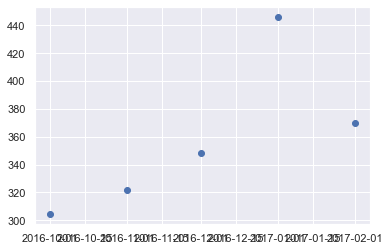

In [537]:
plt.scatter(df_regressao.index, df_regressao.Margem_final)
plt.show();

In [544]:
X_reg = df_regressao.drop(columns='Margem_final')
y_reg = df_regressao.Margem_final

In [545]:
linreg = LinearRegression()

linreg.fit(x_reg, y_reg)

LinearRegression()

In [549]:
pred_reg = linreg.predict(x_reg)
pred_reg

array([314.83048838, 328.35012001, 340.02421783, 451.35553703,
       355.19679505])

In [550]:
y_reg

Data_apuracao
2016-10-01    304.147543
2016-11-01    321.393923
2016-12-01    348.356225
2017-01-01    446.243534
2017-02-01    369.615933
Name: Margem_final, dtype: float64

In [551]:
result = pd.DataFrame(columns = {'data','Margem_real','Margem_predita'})
result['data'] = df_regressao.index
result['Margem_real'] = y_reg.values
result['Margem_predita'] = pred_reg.round(2)
result['Erro'] = result['Margem_predita']/result['Margem_real']
display(result)

,data,Margem_predita,Margem_real,Erro
0,2016-10-01,314.83,304.147543,1.035123
1,2016-11-01,328.35,321.393923,1.021643
2,2016-12-01,340.02,348.356225,0.976070
3,2017-01-01,451.36,446.243534,1.011466
4,2017-02-01,355.20,369.615933,0.960998


## Time Series

In [552]:
#se tivemos mais dados temporais.
df_forecast = df.groupby('Data_apuracao')[['Net_MDR','Pre_pagamento_1','Margem_final']].sum()
#df_forecast['Margem'] = df_forecast['Net_MDR'] + df_forecast['Pre_pagamento_1']
df_forecast

,Net_MDR,Pre_pagamento_1,Margem_final
Data_apuracao,,,
2016-10-01,466473.676991,-6.686220e+05,6.977145e+05
2016-11-01,509835.445824,-7.568483e+05,7.797017e+05
2016-12-01,556566.945840,-1.392623e+06,8.782060e+05
2017-01-01,697286.410786,-9.395753e+05,1.155771e+06
2017-02-01,577278.329723,-4.616177e+05,9.702418e+05


In [553]:
window3 = 3 #janela 3 meses

#media das ultimos 3 meses
df_forecast['trimestral_Net'] = df_forecast['Net_MDR'].rolling(window=window3).mean().round(2)
df_forecast['trimestral_prepag'] = df_forecast['Pre_pagamento_1'].rolling(window=window3).mean().round(2)
df_forecast['trimestral_margem'] = df_forecast['Margem_final'].rolling(window=window3).mean().round(2)

#variação em % trimestral das features
df_forecast['variacao_Net'] = df_forecast['Net_MDR'].pct_change(window3-1).round(4)
df_forecast['variacao_prepag'] = df_forecast['Pre_pagamento_1'].pct_change(window3-1).round(4)
df_forecast['variacao_margem'] = df_forecast['Margem_final'].pct_change(window3-1).round(4)

#correlação entre margem final com Net e preparagemnto
df_forecast['corr_margem_net'] = df_forecast['Margem_final'].rolling(window3).\
            corr(df_forecast['Net_MDR'])
df_forecast['corr_margem_prepag'] = df_forecast['Margem_final'].rolling(window3).\
            corr(df_forecast['Pre_pagamento_1'])


df_forecast

,Net_MDR,Pre_pagamento_1,Margem_final,trimestral_Net,trimestral_prepag,trimestral_margem,variacao_Net,variacao_prepag,variacao_margem,corr_margem_net,corr_margem_prepag
Data_apuracao,,,,,,,,,,,
2016-10-01,466473.676991,-6.686220e+05,6.977145e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-11-01,509835.445824,-7.568483e+05,7.797017e+05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2016-12-01,556566.945840,-1.392623e+06,8.782060e+05,510958.69,-939364.52,785207.39,0.1931,1.0828,0.2587,0.999513,-0.936283
2017-01-01,697286.410786,-9.395753e+05,1.155771e+06,587896.27,-1029682.28,937892.82,0.3677,0.2414,0.4823,0.999909,-0.014607
2017-02-01,577278.329723,-4.616177e+05,9.702418e+05,610377.23,-931272.09,1001406.21,0.0372,-0.6685,0.1048,0.981087,0.310842


In [554]:
#Ajustando o intervalo das features de acordo com a janela de deslocamento e eliminando NANs
#shift para 3 meses para as features e mantem o margem final para dar o predict
df_forecast['Net_MDR'].shift(periods=window3)
df_forecast['Pre_pagamento_1'].shift(periods=window3)
df_forecast['trimestral_Net'].shift(periods=window3)
df_forecast['trimestral_prepag'].shift(periods=window3)
df_forecast['trimestral_margem'].shift(periods=window3)
df_forecast['variacao_Net'].shift(periods=window3)
df_forecast['variacao_prepag'].shift(periods=window3)
df_forecast['variacao_margem'].shift(periods=window3)
df_forecast['corr_margem_net'].shift(periods=window3)
df_forecast['corr_margem_prepag'].shift(periods=window3)
df_forecast = df_forecast.dropna()
df_forecast

,Net_MDR,Pre_pagamento_1,Margem_final,trimestral_Net,trimestral_prepag,trimestral_margem,variacao_Net,variacao_prepag,variacao_margem,corr_margem_net,corr_margem_prepag
Data_apuracao,,,,,,,,,,,
2016-12-01,556566.945840,-1.392623e+06,8.782060e+05,510958.69,-939364.52,785207.39,0.1931,1.0828,0.2587,0.999513,-0.936283
2017-01-01,697286.410786,-9.395753e+05,1.155771e+06,587896.27,-1029682.28,937892.82,0.3677,0.2414,0.4823,0.999909,-0.014607
2017-02-01,577278.329723,-4.616177e+05,9.702418e+05,610377.23,-931272.09,1001406.21,0.0372,-0.6685,0.1048,0.981087,0.310842


In [555]:
X_forecast = df_forecast.drop(columns = ['Margem_final'])
y_forecast = df_forecast.Margem_final

In [556]:
#dado muito pequeno... não vou serpar em teste, treino e validação

In [557]:
scaler = StandardScaler().fit(X_forecast)

x_forecast = scaler.fit_transform(X_forecast)

In [558]:
modelo = lgb.LGBMRegressor(max_depth=10, num_leaves=20, n_estimators=1000)

modelo.fit(x_forecast, y_forecast)

LGBMRegressor(max_depth=10, n_estimators=1000, num_leaves=20)

In [559]:
pred_forecast = modelo.predict(x_forecast)

In [560]:
#metrica - Erro Absoluto Médio Percentual 
def MAPE(y_real, y_pred):
    mape_list = []
    for i in range (0, len(y_real)):
        mape_list.append(np.abs((y_real[i] - y_pred[i])/y_real[i]))
        
    return (np.mean(mape_list))

In [561]:
MAPE(y_forecast, pred_forecast)
#erro do modelo preditivo para os proximos 3 meses de 9,8%

0.10198874188655827

#### Margem média predita para 3 meses

In [565]:
print("Margem de Lucro prevista para daqui a 3 meses: R$" +str(round(np.mean(pred_forecast),2)))

Margem de Lucro prevista para daqui a 3 meses: R$1001406.21


## Extra - MOdelo Machine Learning para predizer Churn

In [367]:
#fazer um modelo ed machine learning para predizer se um cliente vai ou não ficar inativo

In [422]:
df_final2 = pd.get_dummies(df_final, columns = dummies)

In [423]:
df_final2['Data_entrada']=pd.to_datetime(df_final2['Data_entrada'], errors='coerce')

df_final2["Dia"] = df_final2['Data_entrada'].map(lambda x: x.day)
df_final2["Mes"] = df_final2['Data_entrada'].map(lambda
                                             x: x.month)
df_final2["Ano"] = df_final2['Data_entrada'].map(lambda x: x.year)
del df_final2['Data_entrada']

In [424]:
X = df_final2.drop(columns=['Churn'])
y = df_final2.Churn

In [425]:
df_final2.columns

Index(['Nr_cliente', 'Volume_transacionado', 'Qnt_transacoes', 'Net_MDR',
       'Aluguel', 'Pre_pagamento', 'Pre_pagamento_1', 'Equipamento_Logistica',
       'Comissoes', 'Transacionais', 'Outros', 'Margem_final', 'MCC', 'Cidade',
       'Churn', 'labels', 'Canal_Canal 1', 'Canal_Canal 2', 'Canal_Canal 3',
       'Dia', 'Mes', 'Ano'],
      dtype='object')

In [426]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [427]:
encoder = CountFrequencyEncoder(encoding_method='frequency',
                         variables=['MCC','Cidade'])
#
#treinar o endonder
encoder.fit(x_train)

#transformar os dados
x_train = encoder.transform(x_train)
x_test = encoder.transform(x_test)

C:\Users\Helena.Lacaz\Anaconda3\envs\dh_base\lib\site-packages\feature_engine\encoding\base_encoder.py:141: UserWarning: NaN values were introduced in the returned dataframe by the encoder.This means that some of the categories in the input dataframe were not present in the training set used when the fit method was called. Thus, mappings for those categories do not exist. Try using the RareLabelCategoricalEncoder to remove infrequent categories before calling this encoder.
  warnings.warn(


In [428]:
#scaler = preprocessing.RobustScaler().fit(train_t.values)
scaler = preprocessing.StandardScaler().fit(x_train)

#agora vamos normalizar os df treino e teste usando o scaler

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

#caso apareça alguma NaN
x_test[np.isnan(x_test)] = np.median(x_test[~np.isnan(x_test)])

KNeighborsClassifier
****Results****

-----Dados de Treino-----
Accuracy: 0.8846466287571081
Precision: 0.6730769230769231
Recall: 0.3106508875739645

-----Dados de Teste-----
Accuracy: 0.849025974025974
Precision: 0.3888888888888889
Recall: 0.16470588235294117
Matriz Confusão
 [[509  22]
 [ 71  14]]
GaussianNB
****Results****

-----Dados de Treino-----
Accuracy: 0.32372055239642566
Precision: 0.16165221825599185
Recall: 0.9378698224852071

-----Dados de Teste-----
Accuracy: 0.2840909090909091
Precision: 0.15369649805447472
Recall: 0.9294117647058824
Matriz Confusão
 [[ 96 435]
 [  6  79]]
LogisticRegression
****Results****

-----Dados de Treino-----
Accuracy: 0.8623070674248579
Precision: 0.0
Recall: 0.0

-----Dados de Teste-----
Accuracy: 0.862012987012987
Precision: 0.0
Recall: 0.0
Matriz Confusão
 [[531   0]
 [ 85   0]]
DecisionTreeClassifier
****Results****

-----Dados de Treino-----
Accuracy: 1.0


C:\Users\Helena.Lacaz\Anaconda3\envs\dh_base\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision: 1.0
Recall: 1.0

-----Dados de Teste-----
Accuracy: 0.8668831168831169
Precision: 0.5154639175257731
Recall: 0.5882352941176471
Matriz Confusão
 [[484  47]
 [ 35  50]]
RandomForestClassifier
****Results****

-----Dados de Treino-----
Accuracy: 1.0
Precision: 1.0
Recall: 1.0

-----Dados de Teste-----
Accuracy: 0.9090909090909091
Precision: 0.7457627118644068
Recall: 0.5176470588235295
Matriz Confusão
 [[516  15]
 [ 41  44]]
GradientBoostingClassifier
****Results****

-----Dados de Treino-----
Accuracy: 0.950446791226645
Precision: 0.9060150375939849
Recall: 0.7130177514792899

-----Dados de Teste-----
Accuracy: 0.9107142857142857
Precision: 0.75
Recall: 0.5294117647058824
Matriz Confusão
 [[516  15]
 [ 40  45]]
Wall time: 3.09 s


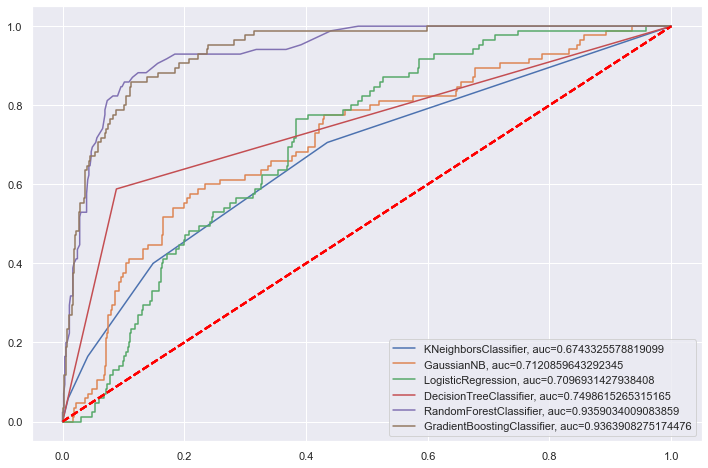

In [429]:
%%time

classifiers = [
    KNeighborsClassifier(),
    GaussianNB(),
    LogisticRegression(),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    GradientBoostingClassifier()]

plt.figure(figsize=(12,8))

for clf in classifiers:
    # instanciando o modelo
    clf.fit(x_train, y_train)
    
    # armazenando o nome do modelo na variável name
    name = clf.__class__.__name__
   
    # imprimindo o nome do modelo
    print("="*30)
    print(name)
    
    # imprimindo os resultados do modelo
    print('****Results****')
    y_pred_test = clf.predict(x_test)
    y_pred_train = clf.predict(x_train)
    
    
    # imprimindo as métricas para os dados de treino
    print('\n-----Dados de Treino-----')
    print("Accuracy:", metrics.accuracy_score(y_train, y_pred_train))
    print("Precision:", metrics.precision_score(y_train, y_pred_train))
    print("Recall:", metrics.recall_score(y_train, y_pred_train))
    
    print('\n-----Dados de Teste-----')
    print("Accuracy:", metrics.accuracy_score(y_test, y_pred_test))
    print("Precision:", metrics.precision_score(y_test, y_pred_test))
    print("Recall:", metrics.recall_score(y_test, y_pred_test))
    print('Matriz Confusão\n',metrics.confusion_matrix(y_test, y_pred_test))
    
    
    #Métricas: Sempre bom lembrar:
    
    #Acurácia: indica uma performance geral do modelo. Dentre todas as classificações,\
    #quantas o modelo classificou corretamente;
    
    #Precisão: dentre todas as classificações de classe Positivo que o modelo fez, \
    #quantas estão corretas;
    
    #Recall: dentre todas as situações de classe Positivo como valor esperado, \
    #quantas estão corretas;
    
    #F1-Score: média harmônica entre precisão e recall.
    
  
    # plotando a curva ROC
    y_pred_proba = clf.predict_proba(x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test,  y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)
    plt.plot(fpr,tpr,label=name+", auc="+str(auc))
    plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--')
    plt.legend(loc=4)

In [ ]:
#Proximos passos
# 1 crossvalidation
# 2 ajustar hiperparêmtros

### Feature Importance

In [442]:
X = df_final2.drop(columns=['Churn'])
y = df_final2.Churn

In [443]:
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [444]:
encoder = CountFrequencyEncoder(encoding_method='frequency',
                         variables=['MCC','Cidade'])
#
#treinar o endonder
encoder.fit(x_train)

#transformar os dados
x_train = encoder.transform(x_train)
x_test = encoder.transform(x_test)

C:\Users\Helena.Lacaz\Anaconda3\envs\dh_base\lib\site-packages\feature_engine\encoding\base_encoder.py:141: UserWarning: NaN values were introduced in the returned dataframe by the encoder.This means that some of the categories in the input dataframe were not present in the training set used when the fit method was called. Thus, mappings for those categories do not exist. Try using the RareLabelCategoricalEncoder to remove infrequent categories before calling this encoder.
  warnings.warn(


In [445]:
#scaler = preprocessing.RobustScaler().fit(train_t.values)
scaler = preprocessing.StandardScaler().fit(x_train)

#agora vamos normalizar os df treino e teste usando o scaler

x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

#caso apareça alguma NaN
x_test[np.isnan(x_test)] = np.median(x_test[~np.isnan(x_test)])

In [447]:
rfc_best = RandomForestClassifier(n_estimators=100, max_depth=20, max_features=10, min_samples_leaf=3, random_state=42, n_jobs=-1)
rfc_best.fit(x_train, y_train)
rfc_best.score(x_train, y_train)

0.9744110479285134

No handles with labels found to put in legend.


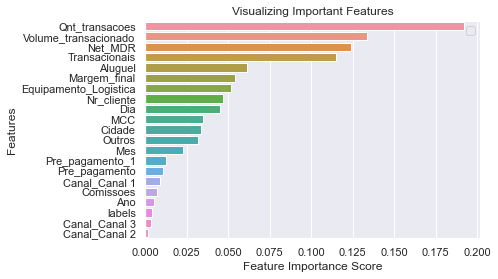

In [448]:
#import pandas as pd
feature_imp = pd.Series(rfc_best.feature_importances_,index=X.columns).sort_values(ascending=False)

#import matplotlib.pyplot as plt
#import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp, y=feature_imp.index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()